# Experiments Adversarial

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

import wandb

import torch
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily


from adversarial_sb.adversarial_ipfp import AdversarialIPFPTrainer
from adversarial_sb.models import SimpleConditional, SimpleCritic, Conditional, Critic
from adversarial_sb.data import OneVariateDataset, MoonsDataset, CirclesDataset, LettersDataset, DigitsDataset
from adversarial_sb.utils import visualize_losses, visualize_gan, visualize_sb, visualize_gan_images, visualize_sb_images


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# One variate

## One mode

In [51]:
# Marginals
marginal_x = Normal(0, 1)
marginal_y = Normal(5, 1)

# Trainer and dataloader parameters
batch_size = 128
dataset = OneVariateDataset(5_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [52]:
# Models parameters
data_dim = 1
hidden_dims = [128, 64, 32]
conditional_q_fixed = SimpleConditional(data_dim, hidden_dims).to(device)

# Init conditional
init_params = {
    'epochs': 120,
    'loader': dataloader,
    'gamma': 2.,
    'lr_disc': 1e-4, 
    'lr_gen': 4e-5,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/120 [00:00<?, ?it/s]

gen Loss: 0.9602499842643738, disc Real Loss: 0.7983833596110343, disc Fake Loss: 0.4910175256431103


KeyboardInterrupt: 

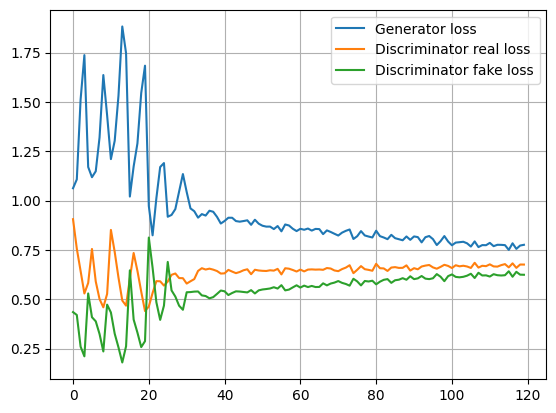

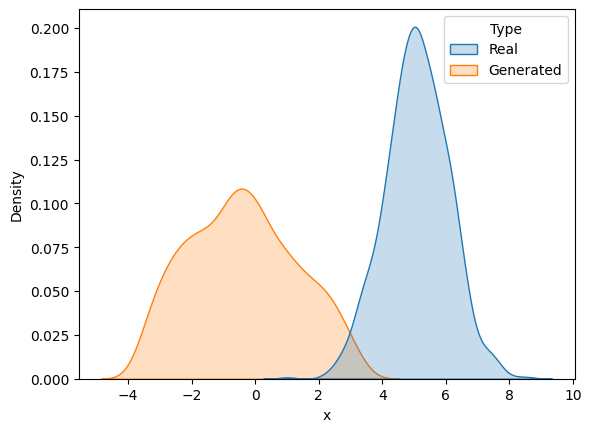

In [ ]:
conditional_q_fixed.to('cpu')

visualize_losses(losses, conditional_q_fixed.loss_titles, inner_steps=1)
visualize_gan(conditional_q_fixed, dataset)

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 80
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: -0.28373, disc_b_fixed: -0.23165, disc_b_training: -0.28385
Backward cond_p: 0.99555, disc_b_fixed: -0.31146, disc_b_training: 0.99489
Backward cond_p: 1.66834, disc_b_fixed: -0.26791, disc_b_training: 1.66830
Backward cond_p: 1.99952, disc_b_fixed: -0.17066, disc_b_training: 1.99945
Backward cond_p: 2.08107, disc_b_fixed: -0.11206, disc_b_training: 2.08110
Forward cond_q: 0.11598, disc_f_fixed: -0.56669, disc_f_training: 0.11587
Forward cond_q: 0.84751, disc_f_fixed: -0.33146, disc_f_training: 0.84384
Forward cond_q: 1.55291, disc_f_fixed: -0.27755, disc_f_training: 1.56263
Forward cond_q: 2.16279, disc_f_fixed: -0.20048, disc_f_training: 2.16318
Forward cond_q: 2.35231, disc_f_fixed: -0.21499, disc_f_training: 2.35589
======= Epoch 1 =======
Backward cond_p: 2.02779, disc_b_fixed: -0.31762, disc_b_training: 2.02537
Backward cond_p: 2.03402, disc_b_fixed: -0.17846, disc_b_training: 2.03334
Backward cond_p: 2.05206, disc_b_fixed: -0.16846, disc_

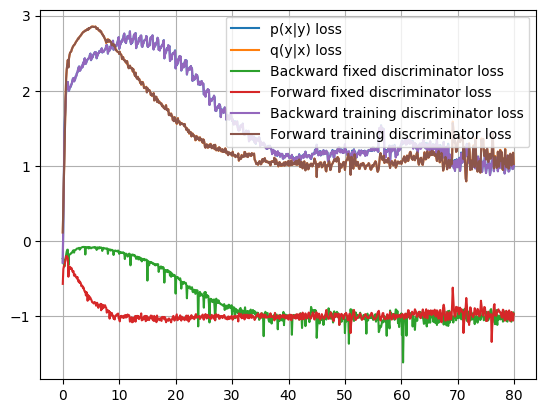

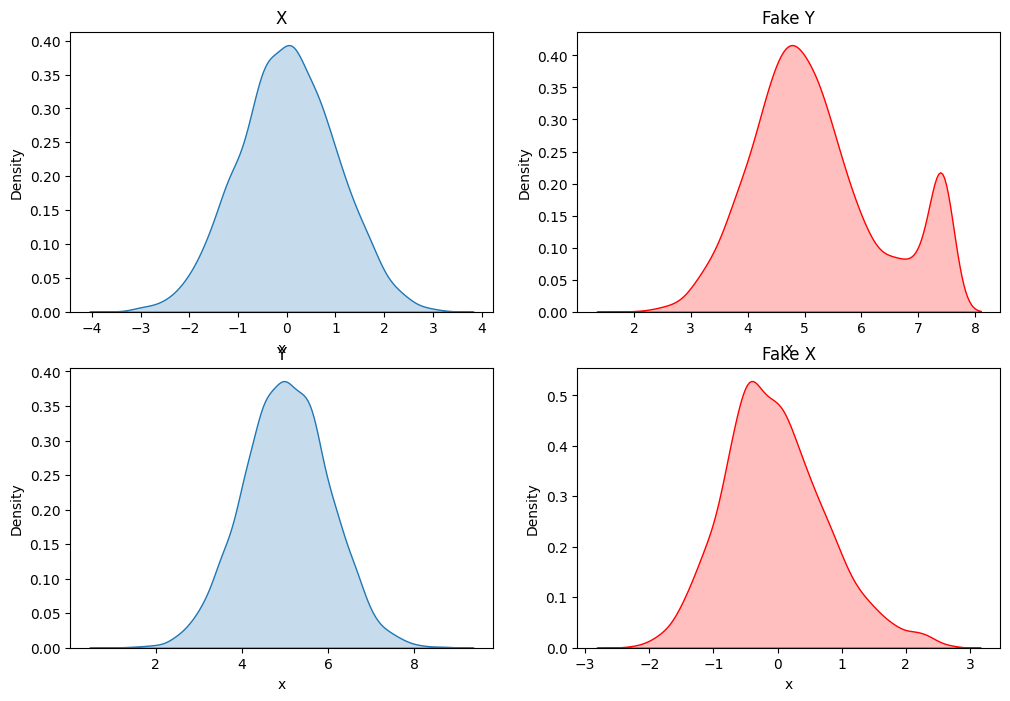

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

## Two modes

In [ ]:
# Marginals
marginal_x = Normal(0, 1)
marginal_y = MixtureSameFamily(
    Categorical(torch.tensor([0.5, 0.5], dtype=torch.float)), 
    Normal(torch.tensor([20, -20], dtype=torch.float), torch.tensor([0.5, 0.5], dtype=torch.float))
)

# Trainer and dataloader parameters
batch_size = 128
dataset = OneVariateDataset(5_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Models parameters
data_dim = 1
hidden_dims = [128, 64, 32]
conditional_q_fixed = SimpleConditional(data_dim, hidden_dims).to(device)

# Init conditional
init_params = {
    'epochs': 500,
    'loader': dataloader,
    'gamma': 10.,
    'lr_disc': 4e-4, 
    'lr_gen': 1e-4,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/500 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'to'

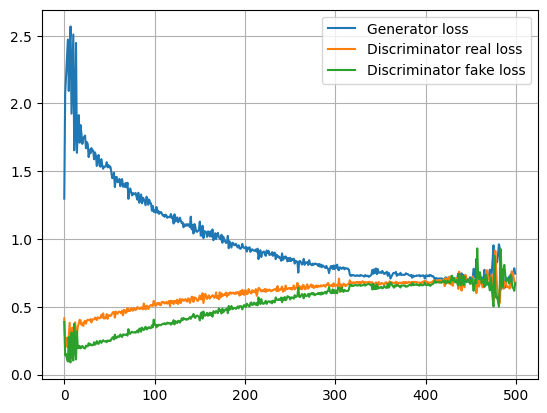

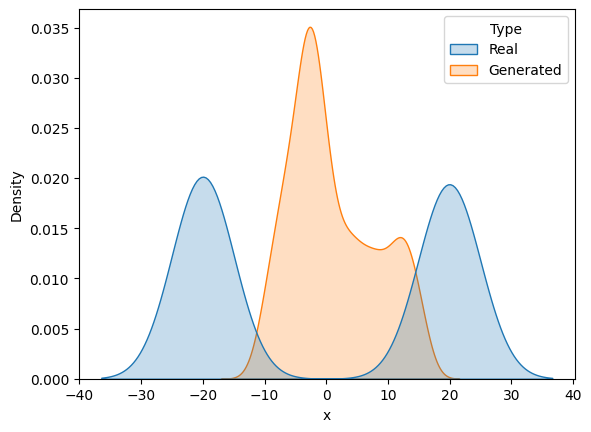

In [ ]:
conditional_q_fixed.to('cpu')

visualize_losses(losses, conditional_q_fixed.loss_titles, inner_steps=1)
visualize_gan(conditional_q_fixed, dataset)

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 100
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.06882, disc_b_fixed: -0.38241, disc_b_training: 0.06879
Backward cond_p: 0.98676, disc_b_fixed: -0.71167, disc_b_training: 0.98666
Backward cond_p: 1.46368, disc_b_fixed: -0.64175, disc_b_training: 1.46345
Backward cond_p: 1.90606, disc_b_fixed: -0.48748, disc_b_training: 1.90594
Backward cond_p: 2.20280, disc_b_fixed: -0.28178, disc_b_training: 2.20246
Forward cond_q: 0.23523, disc_f_fixed: -0.52472, disc_f_training: 0.23874
Forward cond_q: 0.98505, disc_f_fixed: -0.78373, disc_f_training: 0.98823
Forward cond_q: 1.17830, disc_f_fixed: -0.69772, disc_f_training: 1.18277
Forward cond_q: 1.40036, disc_f_fixed: -0.55383, disc_f_training: 1.38292
Forward cond_q: 1.66683, disc_f_fixed: -0.34991, disc_f_training: 1.66477
======= Epoch 1 =======
Backward cond_p: 2.44365, disc_b_fixed: -0.23275, disc_b_training: 2.44257
Backward cond_p: 2.45283, disc_b_fixed: -0.23858, disc_b_training: 2.44970
Backward cond_p: 2.42948, disc_b_fixed: -0.23914, disc_b_

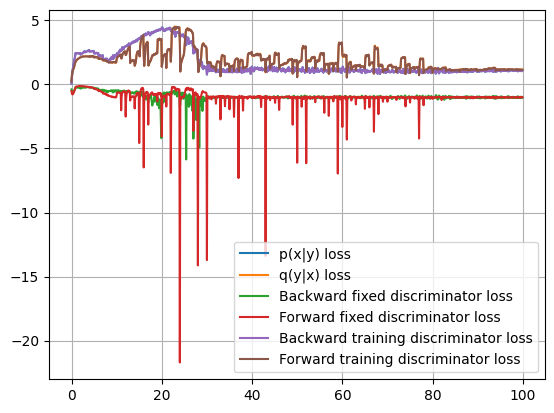

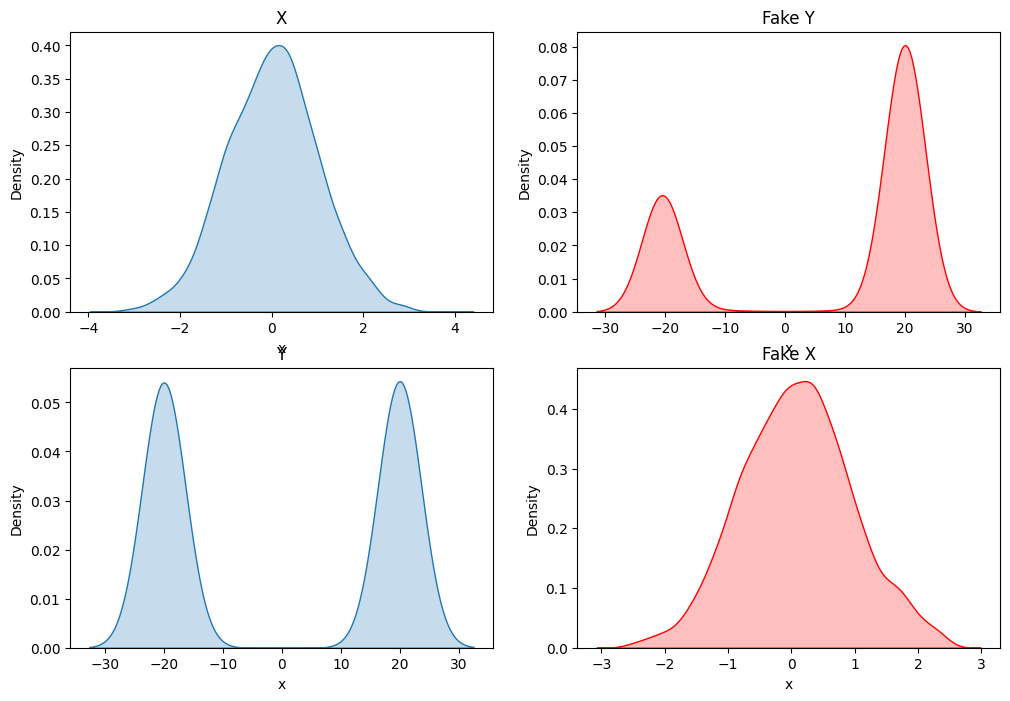

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 200
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.49170, disc_b_fixed: -0.56104, disc_b_training: 0.49169
Backward cond_p: 1.22511, disc_b_fixed: -0.81365, disc_b_training: 1.22504
Backward cond_p: 1.77094, disc_b_fixed: -0.65629, disc_b_training: 1.77089
Backward cond_p: 2.13138, disc_b_fixed: -0.46380, disc_b_training: 2.13141
Backward cond_p: 2.38483, disc_b_fixed: -0.29647, disc_b_training: 2.38470
Forward cond_q: 0.47034, disc_f_fixed: -0.59313, disc_f_training: 0.46639
Forward cond_q: 1.04808, disc_f_fixed: -0.73477, disc_f_training: 1.04901
Forward cond_q: 1.33726, disc_f_fixed: -0.63250, disc_f_training: 1.32820
Forward cond_q: 1.61513, disc_f_fixed: -0.35247, disc_f_training: 1.61887
Forward cond_q: 1.85230, disc_f_fixed: -0.12371, disc_f_training: 1.85272
======= Epoch 1 =======
Backward cond_p: 2.58021, disc_b_fixed: -0.17707, disc_b_training: 2.57999
Backward cond_p: 2.59820, disc_b_fixed: -0.16780, disc_b_training: 2.59848
Backward cond_p: 2.61076, disc_b_fixed: -0.17046, disc_b_

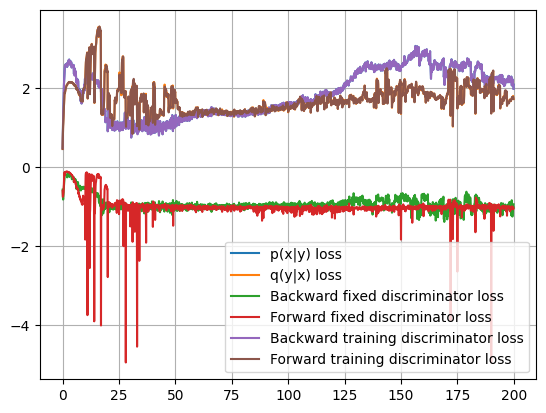

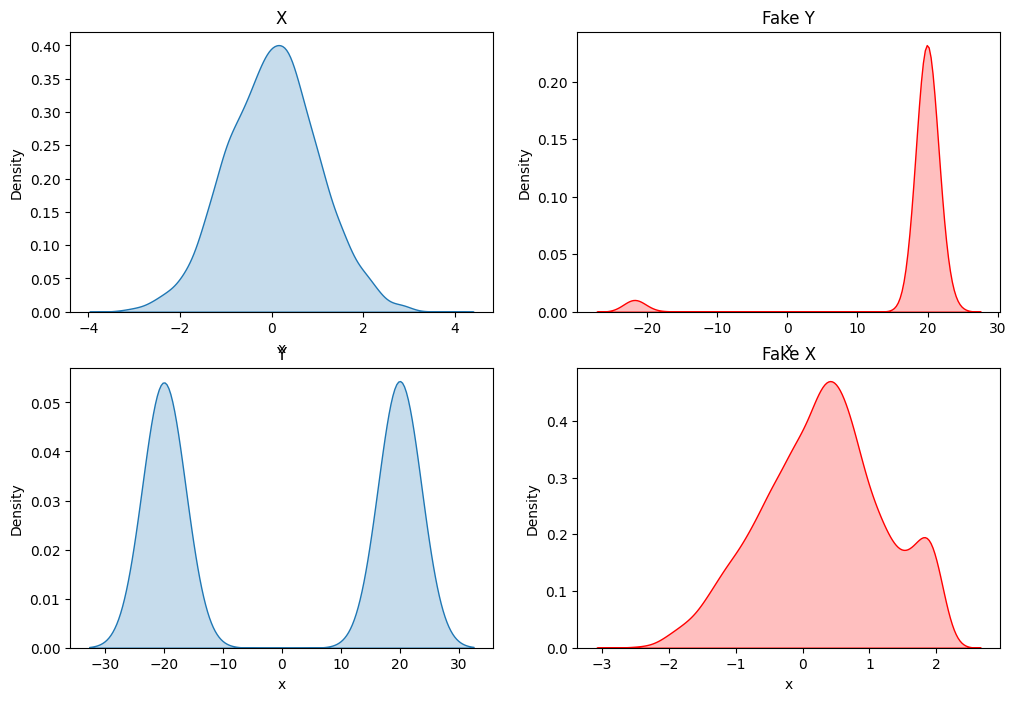

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 5e-5, 'backward': 5e-5},
    lr_gen={'forward': 2e-5, 'backward': 2e-5},
    # clip=0.001,
    device=device
)

epochs = 150
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.45783, disc_b_fixed: -0.64404, disc_b_training: 0.45779
Backward cond_p: 1.14569, disc_b_fixed: -0.77818, disc_b_training: 1.14552
Backward cond_p: 1.61054, disc_b_fixed: -0.51371, disc_b_training: 1.61032
Backward cond_p: 1.69893, disc_b_fixed: -0.46949, disc_b_training: 1.69885
Backward cond_p: 1.78507, disc_b_fixed: -0.41947, disc_b_training: 1.78381
Forward cond_q: 0.20120, disc_f_fixed: -0.50091, disc_f_training: 0.20646
Forward cond_q: 1.16796, disc_f_fixed: -0.72731, disc_f_training: 1.17349
Forward cond_q: 1.56670, disc_f_fixed: -0.55274, disc_f_training: 1.55276
Forward cond_q: 1.82607, disc_f_fixed: -0.23926, disc_f_training: 1.84101
Forward cond_q: 1.97565, disc_f_fixed: -0.15433, disc_f_training: 1.97312
======= Epoch 1 =======
Backward cond_p: 1.94056, disc_b_fixed: -0.66301, disc_b_training: 1.92121
Backward cond_p: 2.12373, disc_b_fixed: -0.46204, disc_b_training: 2.11118
Backward cond_p: 2.12963, disc_b_fixed: -0.48058, disc_b_

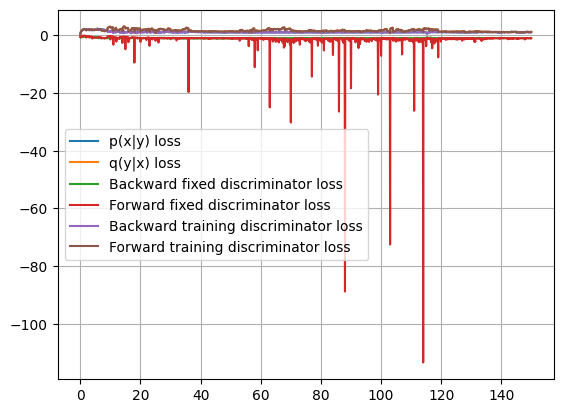

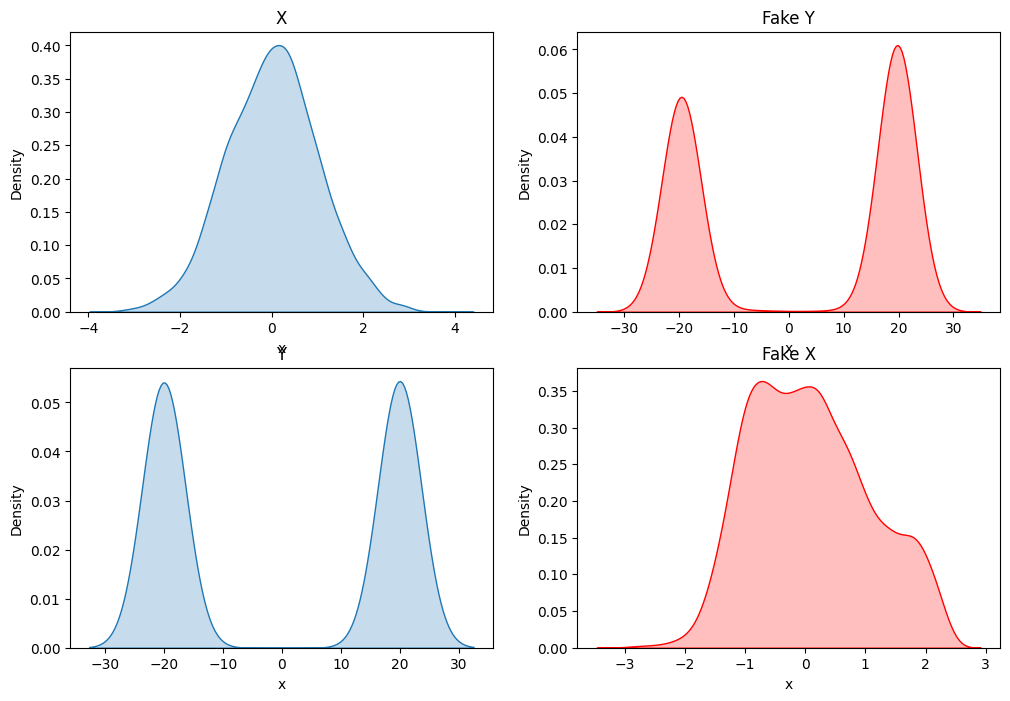

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

# Two variate

In [30]:
batch_size = 512

moons_set = MoonsDataset(5_000)
circles_set = CirclesDataset(5_000)

moons = DataLoader(moons_set, batch_size=batch_size, shuffle=True)
circles = DataLoader(circles_set, batch_size=batch_size, shuffle=True)

In [35]:
# Models parameters
data_dim = 2
hidden_dims = [256]

conditional_q_fixed = SimpleConditional(data_dim, hidden_dims=hidden_dims, latent_dim=32).to(device)


init_params = {
    'epochs': 150,
    'loader': circles,
    'gamma': 1.,
    'lr_disc': 5e-4, 
    'lr_gen': 1e-4,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/150 [00:00<?, ?it/s]

gen Loss: 0.7378956973552704, disc Real Loss: 0.7453475058078766, disc Fake Loss: 0.6539574444293976
gen Loss: 0.6939137876033783, disc Real Loss: 0.6959792792797088, disc Fake Loss: 0.6934444844722748
gen Loss: 0.7055926024913788, disc Real Loss: 0.6851121544837951, disc Fake Loss: 0.683442622423172
gen Loss: 0.7025385499000549, disc Real Loss: 0.6886333882808685, disc Fake Loss: 0.6866420388221741
gen Loss: 0.6944307386875153, disc Real Loss: 0.6891731560230255, disc Fake Loss: 0.6930448174476623
gen Loss: 0.6923093795776367, disc Real Loss: 0.6912756562232971, disc Fake Loss: 0.6944102227687836
gen Loss: 0.6937903046607972, disc Real Loss: 0.6942856431007385, disc Fake Loss: 0.6929637372493744
gen Loss: 0.6911609888076782, disc Real Loss: 0.6914949655532837, disc Fake Loss: 0.695967149734497


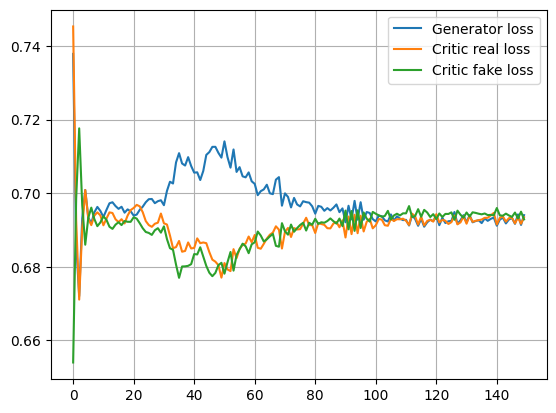

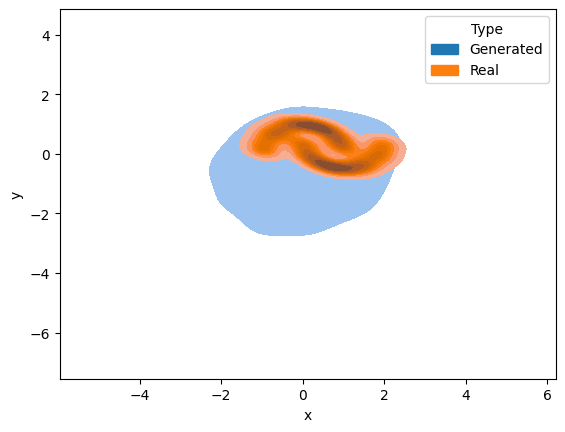

In [36]:
conditional_q_fixed.cpu()

visualize_losses(losses, conditional_q_fixed.loss_titles)
visualize_gan(conditional_q_fixed, circles_set, moons_set)

In [93]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims=[256, 128]).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims=[256, 128]).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 1e-3, 'backward': 1e-3},
    lr_gen={'forward': 5e-4, 'backward': 5e-4},
    clip=0.1,
    device=device
)

losses = trainer.train(1000, circles, moons, inner_steps=2)

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.04931, disc_b_fixed: -0.37948, disc_b_training: 0.04472
Forward cond_q: 0.16671, disc_f_fixed: -0.42696, disc_f_training: 0.16609
======= Epoch 1 =======
Backward cond_p: 0.64519, disc_b_fixed: -0.61463, disc_b_training: 0.64104
Forward cond_q: 0.76192, disc_f_fixed: -0.69389, disc_f_training: 0.76240
======= Epoch 2 =======
Backward cond_p: 1.16517, disc_b_fixed: -0.94961, disc_b_training: 1.15913
Forward cond_q: 1.13853, disc_f_fixed: -1.02957, disc_f_training: 1.13104
======= Epoch 3 =======
Backward cond_p: 1.32083, disc_b_fixed: -1.23150, disc_b_training: 1.31869
Forward cond_q: 1.18972, disc_f_fixed: -1.08409, disc_f_training: 1.17984
======= Epoch 4 =======
Backward cond_p: 1.23352, disc_b_fixed: -1.18901, disc_b_training: 1.22788
Forward cond_q: 1.14316, disc_f_fixed: -1.07327, disc_f_training: 1.13465
======= Epoch 5 =======
Backward cond_p: 1.13051, disc_b_fixed: -1.05361, disc_b_training: 1.12476
Forward cond_q: 1.09604, disc_f_fixe

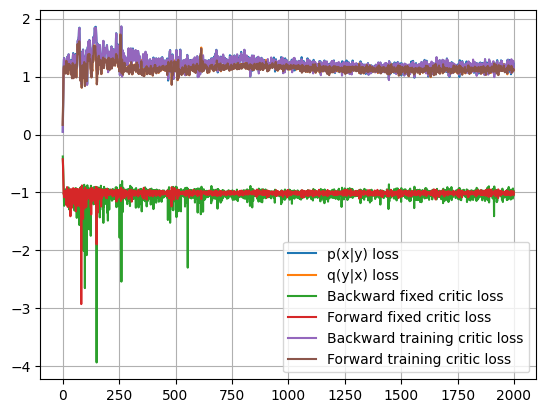

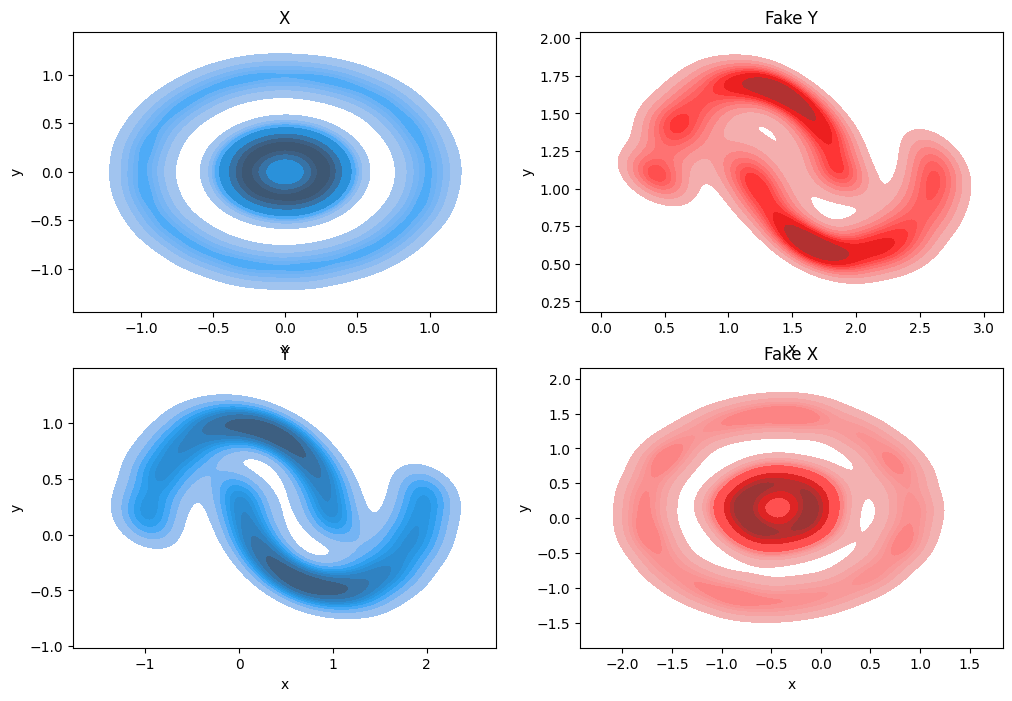

In [94]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles)
visualize_sb(conditional_p, conditional_q, circles_set, moons_set, num_samples=len(circles_set))

# Images: Letters $\rightarrow$ Digits

In [37]:
hyper_params = {
    'data': {
        'batch_size': 32,
        'dataset': 'Letters <-> Digits'
    },
    'init_params': {
        'epochs': 50,
        'gamma': 0.01,
        'lr_disc': 1e-3, 
        'lr_gen': 1e-3 
    },
    'train': {
        'lr_disc': {'forward': 1e-5, 'backward': 1e-5},
        'lr_gen': {'forward': 1e-5, 'backward': 1e-5},
        'epochs': 50,
        'inner_steps': 1,
        'clip': 0.01
    }
}
batch_size = hyper_params['data']['batch_size']

letters_set = LettersDataset('../data/emnist/emnist-letters-train.csv')
digits_set = DigitsDataset('../data/emnist/emnist-mnist-train.csv')

letters = DataLoader(letters_set, batch_size=batch_size, shuffle=True)
digits = DataLoader(digits_set, batch_size=batch_size, shuffle=True)

In [3]:
wandb.login()
wandb.init(
    project="adversarial-sb",
    notes="EMNIST",
    config=hyper_params
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gregkseno. Use `wandb login --relogin` to force relogin


In [38]:
conditional_q_fixed = Conditional(hidden_dims=[32, 64, 128]).to(device)

losses = conditional_q_fixed.init_conditional(loader=letters, **hyper_params['init_params'])
torch.save(conditional_q_fixed.state_dict(), '../models/emnist_conditional_q_fixed.pt')

  0%|          | 0/50 [00:00<?, ?it/s]

gen Loss: 1.6134722791491327, disc Real Loss: 0.36972211273940836, disc Fake Loss: 0.35493123033562224
gen Loss: 3.806423501452884, disc Real Loss: 0.0970877103457177, disc Fake Loss: 0.08228942200675742
gen Loss: 4.7525006807172625, disc Real Loss: 0.061993927934483904, disc Fake Loss: 0.050566315566030175
gen Loss: 5.521959325601388, disc Real Loss: 0.04628056891031798, disc Fake Loss: 0.036718260841360234
gen Loss: 5.975327345444275, disc Real Loss: 0.03965088720087315, disc Fake Loss: 0.031057099507039262
gen Loss: 6.478285005157058, disc Real Loss: 0.033402666067610165, disc Fake Loss: 0.02606697522154128
gen Loss: 6.871536366574399, disc Real Loss: 0.02946707115147309, disc Fake Loss: 0.02286041601674279
gen Loss: 7.213996943568324, disc Real Loss: 0.029143593643722755, disc Fake Loss: 0.022262957024205526
gen Loss: 7.536967190579251, disc Real Loss: 0.026742406338589635, disc Fake Loss: 0.019746099019182953
gen Loss: 7.831954415295575, disc Real Loss: 0.01958087046058305, disc F

In [28]:
conditional_q_fixed = Conditional(hidden_dims=[32, 64, 128]).to(device)
conditional_q_fixed.load_state_dict(torch.load('../models/emnist_conditional_q_fixed.pt'))

<All keys matched successfully>

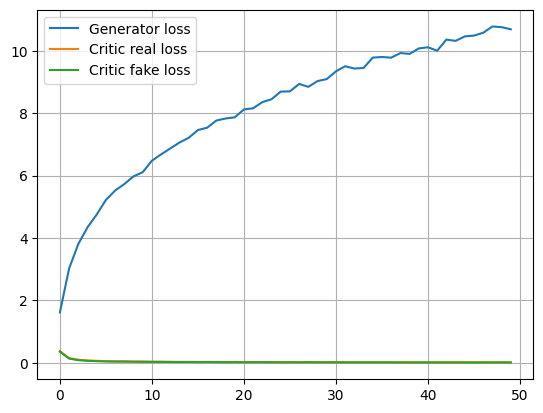

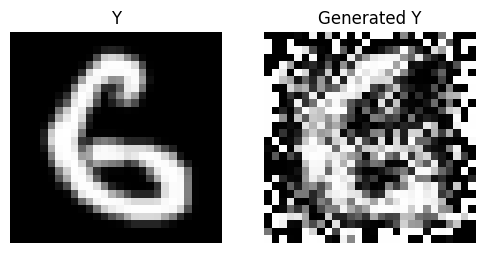

In [39]:
conditional_q_fixed.cpu().eval()

visualize_losses(losses, conditional_q_fixed.loss_titles)
visualize_gan_images(conditional_q_fixed, letters_set)

In [44]:
from copy import deepcopy

# discriminator_backward = Critic(hidden_dims=[128, 64, 32]).to(device)
# discriminator_forward = Critic(hidden_dims=[128, 64, 32]).to(device)

# conditional_q_fixed.train()
# conditional_p = Conditional(hidden_dims=[32, 64, 128]).to(device)
# conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc=hyper_params['train']['lr_disc'],
    lr_gen=hyper_params['train']['lr_gen'],
    clip=hyper_params['train']['clip'],
    device=device
)

losses = trainer.train(hyper_params['train']['epochs'], letters, digits, inner_steps=hyper_params['train']['inner_steps'])

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 12.59587, disc_b_fixed: 84.66132, disc_b_training: -12.59074
Forward cond_q: 13.24994, disc_f_fixed: 13.95650, disc_f_training: -13.24711
======= Epoch 1 =======
Backward cond_p: 12.68196, disc_b_fixed: 2.84333, disc_b_training: -12.67994
Forward cond_q: 13.30907, disc_f_fixed: 7.53794, disc_f_training: -13.30265
======= Epoch 2 =======
Backward cond_p: 12.95950, disc_b_fixed: 2.96078, disc_b_training: -12.95506
Forward cond_q: 13.44790, disc_f_fixed: 6.67749, disc_f_training: -13.44518
======= Epoch 3 =======
Backward cond_p: 13.27086, disc_b_fixed: 1.63013, disc_b_training: -13.26745
Forward cond_q: 13.79594, disc_f_fixed: 3.11478, disc_f_training: -13.79334
======= Epoch 4 =======
Backward cond_p: 13.71490, disc_b_fixed: 2.76333, disc_b_training: -13.71152
Forward cond_q: 14.14867, disc_f_fixed: 4.43182, disc_f_training: -14.14138
======= Epoch 5 =======
Backward cond_p: 14.03523, disc_b_fixed: 2.07797, disc_b_training: -14.03124
Forward cond

In [29]:
wandb.finish()

In [43]:
conditional_q.to('cuda')
conditional_p.to('cuda')

# conditional_q.eval()
# conditional_p.eval()

# visualize_losses(losses, trainer.loss_titles, inner_steps=hyper_params['train']['inner_steps'])
# visualize_sb_images(conditional_p, conditional_q, letters_set, digits_set, x_title='Letter', y_title='Digit', num_samples=16)

Conditional(
  (embed): Linear(in_features=100, out_features=784, bias=True)
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1568, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=128, bias=True)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=128, out_features=784, bias=True)
    )
    (1): Tanh()
  )
)

In [16]:
torch.save(conditional_p.state_dict(), '../models/emnist3_conditional_p.pt')
torch.save(conditional_q.state_dict(), '../models/emnist3_conditional_q.pt')

In [3]:
conditional_p = Conditional(hidden_dims=[256, 256], num_classes=10)
conditional_p.load_state_dict(torch.load('../models/emnist3_conditional_p.pt'))

conditional_q = Conditional(hidden_dims=[256, 256], num_classes=26)
conditional_q.load_state_dict(torch.load('../models/emnist3_conditional_q.pt'))

<All keys matched successfully>